In [1]:
import sys
sys.path.append("../")
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import ThinLens.Elements as Elements
import ThinLens.Maps as Maps
from ThinLens.Models import F0D0Model, SIS18_Cell_minimal, SIS18_Cell, \
    SIS18_Lattice_minimal, SIS18_Lattice

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from IPython.display import set_matplotlib_formats, display
set_matplotlib_formats('pdf', "svg")
import matplotlib.pyplot as plt
import numpy as np

import cpymad.madx

from ThinLens.Beam import Beam
import tools.plot

In [2]:
# general
# torch.set_printoptions(precision=4, sci_mode=False)

dim = 6
slices = 4
quadSliceMultiplicity = 1
dtype = torch.double
device = torch.device("cpu")
outputPerElement = True  # exceeds outputAtBPM
outputAtBPM = True

# set up models
Lattice = SIS18_Lattice

model = Lattice(dim=dim, slices=slices, quadSliceMultiplicity=quadSliceMultiplicity,
                dtype=dtype,).to(device)

perturbedModel = Lattice(dim=dim, slices=slices, quadSliceMultiplicity=quadSliceMultiplicity,
                         dtype=dtype).to(device)

model.requires_grad_(False)
perturbedModel.requires_grad_(False)

SIS18_Lattice(
  (elements): ModuleList(
    (0): Drift(
      (map): DriftMap()
      (maps): ModuleList(
        (0): DriftMap()
      )
    )
    (1): RBen(
      (maps): ModuleList(
        (0): EdgeKick()
        (1): DriftMap()
        (2): DipoleKick()
        (3): DriftMap()
        (4): DriftMap()
        (5): DipoleKick()
        (6): DriftMap()
        (7): DriftMap()
        (8): DipoleKick()
        (9): DriftMap()
        (10): DriftMap()
        (11): DipoleKick()
        (12): DriftMap()
        (13): EdgeKick()
      )
    )
    (2): Drift(
      (map): DriftMap()
      (maps): ModuleList(
        (0): DriftMap()
      )
    )
    (3): RBen(
      (maps): ModuleList(
        (0): EdgeKick()
        (1): DriftMap()
        (2): DipoleKick()
        (3): DriftMap()
        (4): DriftMap()
        (5): DipoleKick()
        (6): DriftMap()
        (7): DriftMap()
        (8): DipoleKick()
        (9): DriftMap()
        (10): DriftMap()
        (11): DipoleKick()
        (

In [3]:
# perturb model
relDev = 1e-2
for element in perturbedModel.elements:
    if type(element) is Elements.Quadrupole:
        k1n = element.k1n.item()
        k1n = torch.normal(k1n, relDev*abs(k1n), size=(1,))
        element.k1n = nn.Parameter(k1n, requires_grad=False)
        element.shareWeights()

In [4]:
# train set
beam = Beam(mass=18.798, energy=19.0, exn=1.258e-6, eyn=2.005e-6, sigt=0.01, sige=0.000, particles=500)
bunch = beam.bunch[:].to(device)
label = perturbedModel(bunch, outputPerElement=outputPerElement, outputAtBPM=outputAtBPM).to(device)

trainSet = torch.utils.data.TensorDataset(bunch, label)
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=25,
                                          shuffle=True, num_workers=2)


plot initial model properties

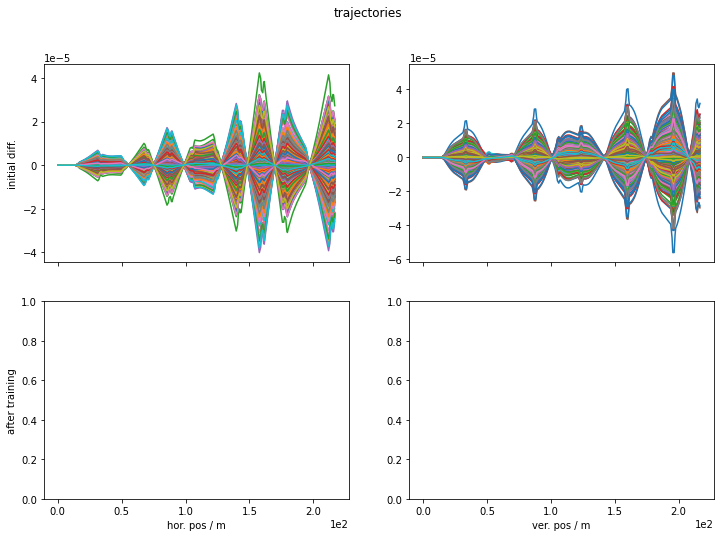

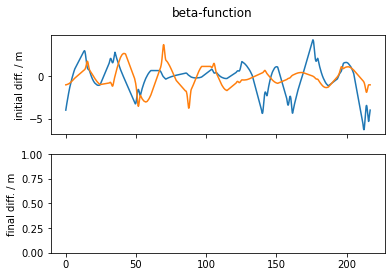

In [5]:
# plot initial trajectories
figTrajectories, axesTrajectories = plt.subplots(2, 2, sharex=True, figsize=(12,8))
figTrajectories.suptitle("trajectories")

for i in range(len(axesTrajectories)):
    for j in range(len(axesTrajectories[i])):
        axesTrajectories[i, j].ticklabel_format(style="sci", scilimits=(0,0))

initialTrajectoriesDifference = tools.plot.track(model, bunch, 1) - tools.plot.track(perturbedModel, bunch, 1)
tools.plot.trajectories(axesTrajectories[0, 0], initialTrajectoriesDifference, model, plane="x")
tools.plot.trajectories(axesTrajectories[0, 1], initialTrajectoriesDifference, model, plane="y")

axesTrajectories[0, 0].set_ylabel("initial diff.")
axesTrajectories[1, 0].set_ylabel("after training")
axesTrajectories[1, 0].set_xlabel("hor. pos / m")
axesTrajectories[1, 1].set_xlabel("ver. pos / m")

# plot inital beta
modelTwiss, perturbedTwiss = model.getTwiss(), perturbedModel.getTwiss()

figBeta, axesBeta = plt.subplots(2, sharex=True)
figBeta.suptitle("beta-function")
try:
    axesBeta[0].plot(modelTwiss["s"], modelTwiss["betx"] - perturbedTwiss["betx"], label="hor.")
    axesBeta[0].plot(modelTwiss["s"], modelTwiss["bety"] - perturbedTwiss["bety"], label="ver.")
except ThinLens.Models.TwissFailed as e:
    print(e)
    print("warning twiss failed")

axesBeta[0].set_ylabel("initial diff. / m")
axesBeta[1].set_ylabel("final diff. / m")

plt.show()

Text(0.5, 0, 'pos / m')

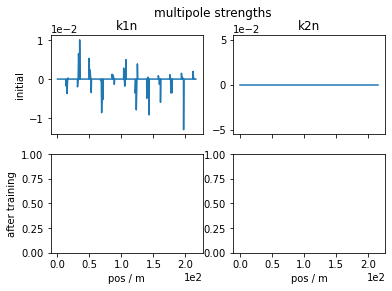

In [6]:
# visualize difference in multipole components
def compareMultipoleStrengths(modelA, modelB):
    diff_k1n, diff_k2n = np.empty(len(modelA.elements)), np.empty(len(modelA.elements))
    diff_k1s, diff_k2s = np.empty(len(modelA.elements)), np.empty(len(modelA.elements))

    for i in range(len(modelA.elements)):
        if type(modelA.elements[i]) is Elements.Quadrupole:
            diff_k1n[i] = modelA.elements[i].k1n.item() - modelB.elements[i].k1n.item()
            diff_k1s[i] = modelA.elements[i].k1s.item() - modelB.elements[i].k1s.item()
            diff_k2n[i] = modelA.elements[i].k2n.item() - modelB.elements[i].k2n.item()
            diff_k2s[i] = modelA.elements[i].k2s.item() - modelB.elements[i].k2s.item()
        else:
            diff_k1n[i] = 0
            diff_k1s[i] = 0
            diff_k2n[i] = 0
            diff_k2s[i] = 0

    return tuple([(diff_k1n, diff_k2n), (diff_k1s, diff_k2s),])

initialDiffNormal, initialDiffSkew = compareMultipoleStrengths(model, perturbedModel)

multipoleFig, multipoleAxes = plt.subplots(2, 2, sharex=True)
multipoleFig.suptitle("multipole strengths")


for i in range(len(multipoleAxes)):
    for j in range(len(multipoleAxes[i])):
        multipoleAxes[i, j].ticklabel_format(style="sci", scilimits=(0,0))

multipoleAxes[0, 0].plot(model.positions, initialDiffNormal[0])
multipoleAxes[0, 1].plot(model.positions, initialDiffNormal[1])

multipoleAxes[0, 0].set_title("k1n")
multipoleAxes[0, 1].set_title("k2n")
multipoleAxes[0, 0].set_ylabel("initial")
multipoleAxes[1, 0].set_ylabel("after training")

multipoleAxes[1, 0].set_xlabel("pos / m")
multipoleAxes[1, 1].set_xlabel("pos / m")

setup training

In [7]:
# activate gradients on kick maps
for element in model.elements:
    if type(element) is Elements.Quadrupole:
        element.k1n.requires_grad_(True)
        element.k2n.requires_grad_(True)
        
        # currently twiss parameters cannot be calculated for coupled motion
        element.k1s.requires_grad_(False)
        element.k2s.requires_grad_(False)

# set up optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()


In [8]:
epochs = 5

# train loop
t0 = time.time()

for epoch in range(epochs):
    for i, data in enumerate(trainLoader, 0):
        bunch, label = data[0], data[1]

        optimizer.zero_grad()

        out = model(bunch, outputPerElement=outputPerElement, outputAtBPM=outputAtBPM)

        # loss = criterion(out, label)  # full phase-space
        loss = criterion(out[:, [0, 2], :], label[:, [0, 2], :])  # only x-, y-plane

        loss.backward()
        optimizer.step()

    # if epoch % 10 == 9:
    #     print(loss.item())
    print(loss.item())

print("training completed within {:.2f}s".format(time.time() - t0))

/home/conrad/miniconda3/envs/FODO/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


1.383403938247192e-12
2.6472547644473994e-13
1.3681172563577603e-13
1.7003502719877805e-13
7.571671113031e-14
training completed within 148.30s


visualize model performance after training

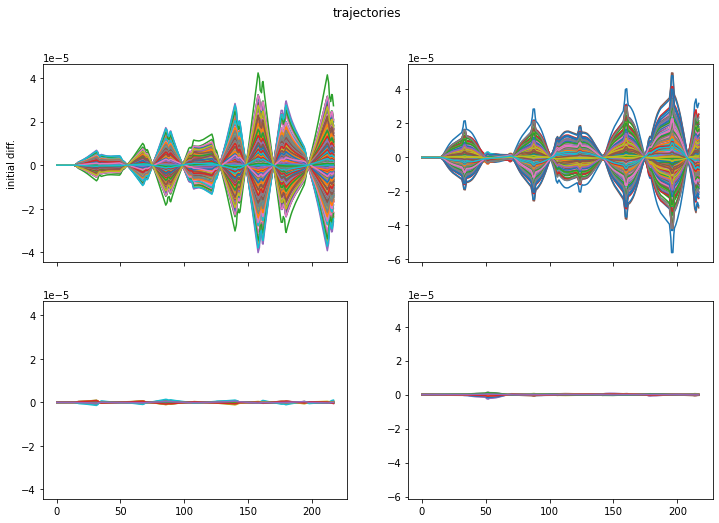

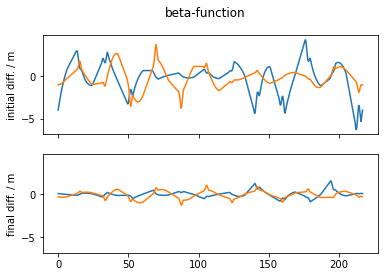

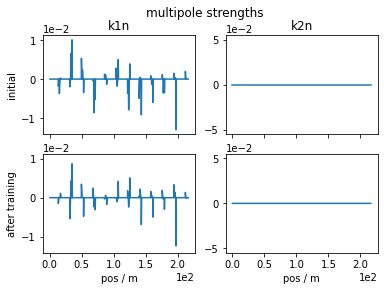

In [9]:
perturbedModel# plot final trajectories
trajectoriesDifference = tools.plot.track(model, bunch, 1) - tools.plot.track(perturbedModel, bunch, 1)

axesTrajectories[1, 0].clear()
tools.plot.trajectories(axesTrajectories[1, 0], trajectoriesDifference, model, plane="x")
axesTrajectories[1, 0].set_ylim(axesTrajectories[0, 0].get_ylim())

axesTrajectories[1, 1].clear()
tools.plot.trajectories(axesTrajectories[1, 1], trajectoriesDifference, model, plane="y")
axesTrajectories[1, 1].set_ylim(axesTrajectories[0, 1].get_ylim())

display(figTrajectories)


# plot final beta
finalModelTwiss = model.getTwiss()
try:
    axesBeta[1].plot(modelTwiss["s"], finalModelTwiss["betx"] - perturbedTwiss["betx"], label="hor.")
    axesBeta[1].plot(modelTwiss["s"], finalModelTwiss["bety"] - perturbedTwiss["bety"], label="ver.")
    
    axesBeta[1].set_ylim(axesBeta[0].get_ylim())
except ThinLens.Models.TwissFailed as e:
    print(e)
    print("warning twiss failed")

display(figBeta)

# plot final deviation in multipole strengths
finalDiffNormal, finalDiffSkew = compareMultipoleStrengths(model, perturbedModel)

multipoleAxes[1, 0].plot(model.positions, finalDiffNormal[0])
multipoleAxes[1, 0].set_ylim(multipoleAxes[0, 0].get_ylim())

multipoleAxes[1, 1].plot(model.positions, finalDiffNormal[1])
multipoleAxes[1, 1].set_ylim(multipoleAxes[0, 1].get_ylim())

display(multipoleFig)

look at multipole strengths

In [11]:
for element in model.elements:
    if type(element) is Elements.Quadrupole:
        print("k2n={:.2e}, k2s={:.2e}".format(element.k2n.item(), element.k2s.item()))

k2n=1.65e-08, k2s=0.00e+00
k2n=4.30e-08, k2s=0.00e+00
k2n=2.35e-08, k2s=0.00e+00
k2n=8.27e-08, k2s=0.00e+00
k2n=1.57e-08, k2s=0.00e+00
k2n=1.74e-08, k2s=0.00e+00
k2n=-1.60e-07, k2s=0.00e+00
k2n=-2.52e-07, k2s=0.00e+00
k2n=-8.72e-08, k2s=0.00e+00
k2n=6.79e-08, k2s=0.00e+00
k2n=9.24e-08, k2s=0.00e+00
k2n=3.61e-08, k2s=0.00e+00
k2n=1.45e-07, k2s=0.00e+00
k2n=1.44e-07, k2s=0.00e+00
k2n=4.18e-08, k2s=0.00e+00
k2n=-8.35e-08, k2s=0.00e+00
k2n=-9.36e-08, k2s=0.00e+00
k2n=-4.59e-08, k2s=0.00e+00
k2n=4.57e-08, k2s=0.00e+00
k2n=4.90e-08, k2s=0.00e+00
k2n=1.27e-08, k2s=0.00e+00
k2n=-1.09e-07, k2s=0.00e+00
k2n=-1.36e-07, k2s=0.00e+00
k2n=-5.75e-08, k2s=0.00e+00
k2n=-3.78e-08, k2s=0.00e+00
k2n=-1.74e-08, k2s=0.00e+00
k2n=-4.20e-09, k2s=0.00e+00
k2n=6.04e-08, k2s=0.00e+00
k2n=8.91e-08, k2s=0.00e+00
k2n=2.98e-08, k2s=0.00e+00
k2n=-1.43e-08, k2s=0.00e+00
k2n=-1.10e-08, k2s=0.00e+00
k2n=-5.49e-09, k2s=0.00e+00
k2n=-9.73e-09, k2s=0.00e+00
k2n=-4.00e-09, k2s=0.00e+00
k2n=-3.56e-10, k2s=0.00e+00


In [12]:
for element in model.elements:
    if type(element) is Elements.Quadrupole:
        print("k1n={:.2e}, k1s={:.2e}".format(element.k1n.item(), element.k1s.item()))

k1n=3.13e-01, k1s=0.00e+00
k1n=-4.74e-01, k1s=0.00e+00
k1n=6.26e-01, k1s=0.00e+00
k1n=3.09e-01, k1s=0.00e+00
k1n=-4.80e-01, k1s=0.00e+00
k1n=6.23e-01, k1s=0.00e+00
k1n=3.11e-01, k1s=0.00e+00
k1n=-4.80e-01, k1s=0.00e+00
k1n=6.23e-01, k1s=0.00e+00
k1n=3.15e-01, k1s=0.00e+00
k1n=-4.72e-01, k1s=0.00e+00
k1n=6.27e-01, k1s=0.00e+00
k1n=3.11e-01, k1s=0.00e+00
k1n=-4.78e-01, k1s=0.00e+00
k1n=6.24e-01, k1s=0.00e+00
k1n=3.09e-01, k1s=0.00e+00
k1n=-4.77e-01, k1s=0.00e+00
k1n=6.24e-01, k1s=0.00e+00
k1n=3.18e-01, k1s=0.00e+00
k1n=-4.73e-01, k1s=0.00e+00
k1n=6.26e-01, k1s=0.00e+00
k1n=3.18e-01, k1s=0.00e+00
k1n=-4.76e-01, k1s=0.00e+00
k1n=6.27e-01, k1s=0.00e+00
k1n=3.13e-01, k1s=0.00e+00
k1n=-4.76e-01, k1s=0.00e+00
k1n=6.26e-01, k1s=0.00e+00
k1n=3.13e-01, k1s=0.00e+00
k1n=-4.75e-01, k1s=0.00e+00
k1n=6.25e-01, k1s=0.00e+00
k1n=3.14e-01, k1s=0.00e+00
k1n=-4.77e-01, k1s=0.00e+00
k1n=6.25e-01, k1s=0.00e+00
k1n=3.12e-01, k1s=0.00e+00
k1n=-4.78e-01, k1s=0.00e+00
k1n=6.25e-01, k1s=0.00e+00
